## Installing necessary packages

In [ ]:
#Installing earthpy for visualisation purposes
!pip install earthpy

In [ ]:
import matplotlib.pyplot as plt

import numpy as np
import earthpy.plot as ep
import seaborn as sns
import earthpy.spatial as es

import plotly.graph_objects as go
import plotly.express as px

from scipy.io import loadmat

import pandas as pd

from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,
                             confusion_matrix, classification_report)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, MaxPooling2D, Dropout, Flatten, Conv2D, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

from tqdm import tqdm
from numpy.random import seed
from time import time

seed(11)

## Helper functions to pre-process the data.

In [ ]:
#GLOBAL VARIABLES
test_ratio = 0.3
windowSize = 3

In [ ]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [ ]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [ ]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    #print(patchesLabels[0])
    return patchesData, patchesLabels

## Loading the data.

In [ ]:
# X data (1096, 715, 102)   Hyperspectral satellite   (1096*715, 102)
data = loadmat('PaviaU.mat')['paviaU']


# Y data (labels)
gt = loadmat('PaviaU_gt.mat')['paviaU_gt']

print(f'Data Shape: {data.shape[:-1]}\nNumber of Bands: {data.shape[-1]}')

Data Shape: (610, 340)
Number of Bands: 103


In [ ]:
X, Y = createImageCubes(data, gt, windowSize=windowSize, removeZeroLabels = True)
X.shape, Y.shape

((42776, 3, 3, 103), (42776,))

In [ ]:
Y.shape, np.min(Y), np.max(Y)

((42776,), 0.0, 8.0)

In [ ]:
X_train, X_test, y_train, y_test = splitTrainTestSet(X, Y, test_ratio)
X_train, X_val, y_train, y_val = splitTrainTestSet(X_train, y_train, test_ratio)

## Visualising various bands from the data.

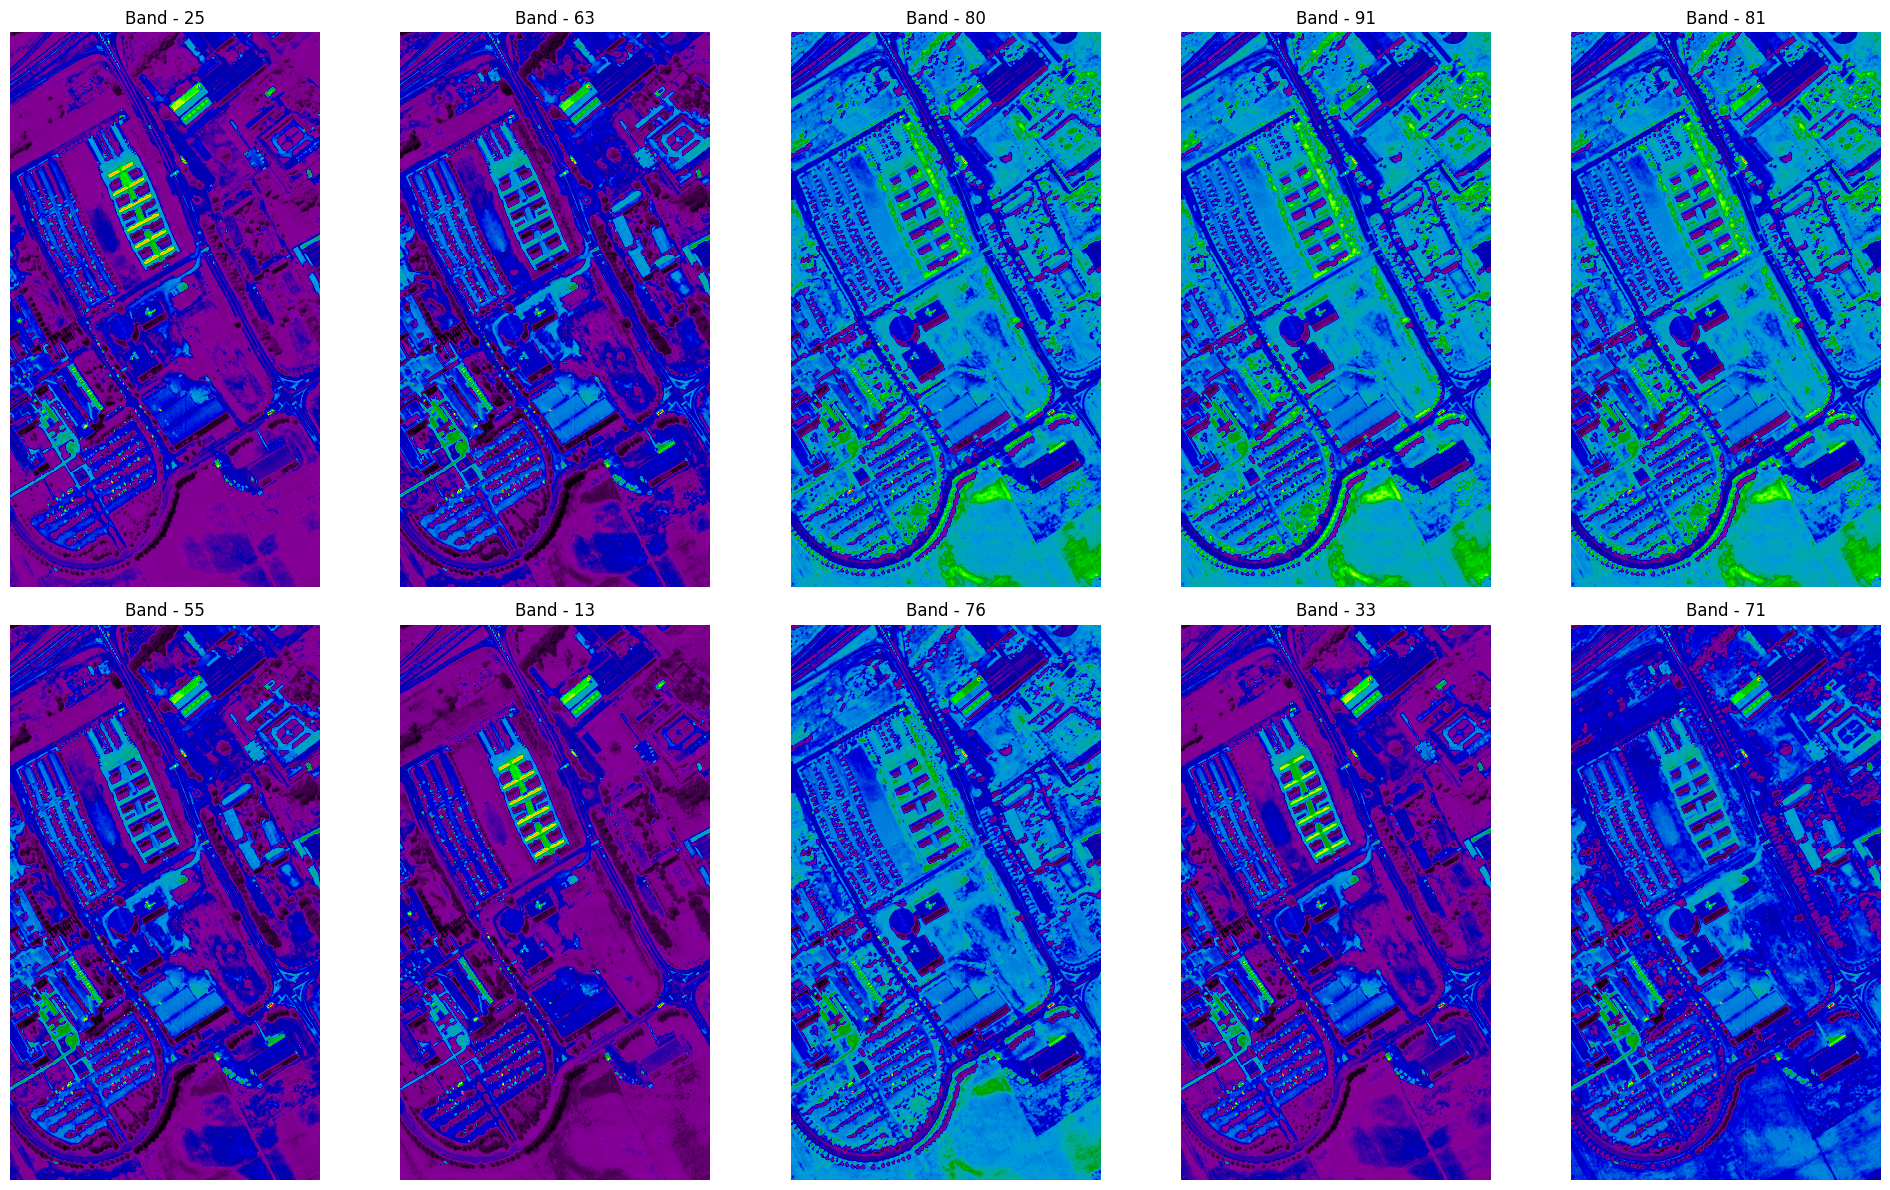

In [ ]:
fig = plt.figure(figsize = (20, 12))

ax = fig.subplots(2, 5)

for i in range(2):
  for j in range(5):
    c = np.random.randint(103)
    ax[i][j].imshow(data[:, :, c], cmap='nipy_spectral')
    ax[i][j].axis('off')
    ax[i][j].title.set_text(f"Band - {c}")
    c+=1

plt.tight_layout()
plt.show()

## Visualising the Original Landscape.

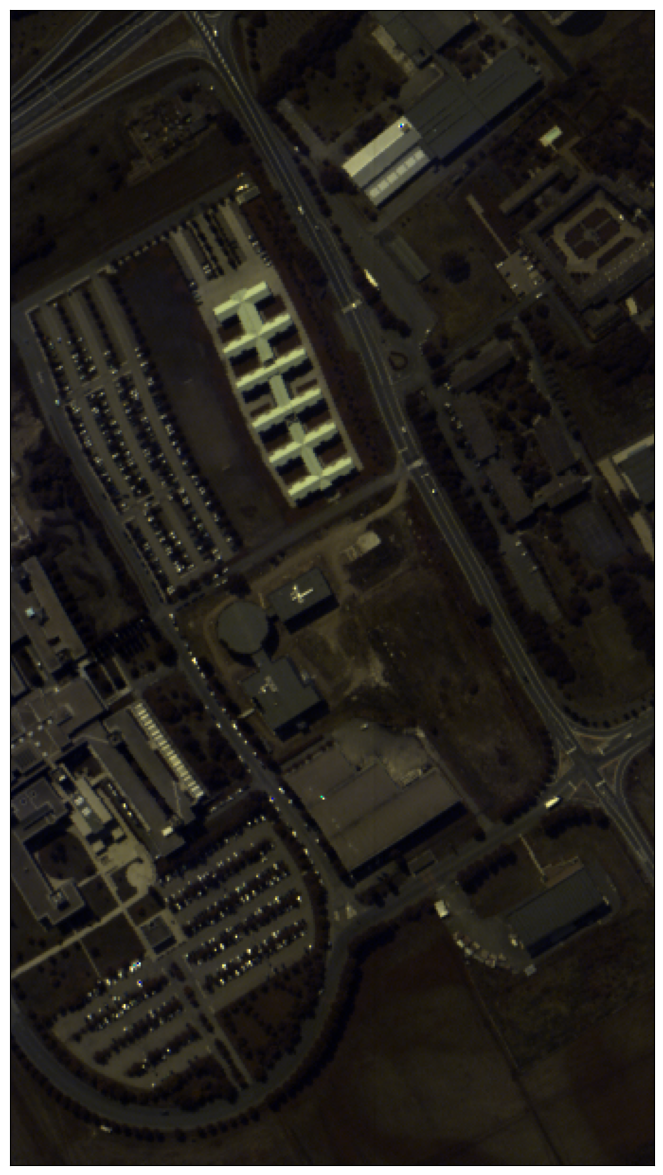

In [ ]:
mdata = np.moveaxis(data, -1, 0)

ep.plot_rgb(mdata, (29, 23, 2), figsize=(15, 15))

plt.show()

## Visualising the ground truth hyperspectral image.

In [ ]:
def plot_data(data):
  fig = plt.figure(figsize=(12, 10))
  plt.imshow(data, cmap='nipy_spectral')
  plt.colorbar()
  plt.axis('on')
  plt.show()

#plot_data(gt)

## Setting up the Conv2D Model.

In [ ]:
n_outputs=9

In [ ]:
#(n,W,H,B)
X_train.shape

(20960, 3, 3, 103)

In [ ]:
model = Sequential(name = 'PaviaUCNN')

model.add(Conv2D(64, kernel_size=(2, 2),activation='linear',padding='same',input_shape=(3,3,103)))
model.add(LeakyReLU(alpha=0.1))
#model.add(MaxPooling2D((2, 2),padding='same'))

model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))
#model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))

model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))

model.add(Flatten())

model.add(Dense(20, activation='linear'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.4))

model.add(Dense(n_outputs, activation='softmax'))
model.summary()

Model: "PaviaUCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 3, 3, 64)          26432     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 3, 3, 64)          0         
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 128)         73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 3, 3, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         147584    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 3, 3, 128)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 2, 2, 128)        0 

In [ ]:
y_train[0]

0.0

In [ ]:
y_train_cat=tf.keras.utils.to_categorical(y_train)
y_train_cat.shape

(20960, 9)

In [ ]:
y_val_cat=tf.keras.utils.to_categorical(y_val)
y_val_cat.shape

(8983, 9)

In [ ]:
y_test_cat=tf.keras.utils.to_categorical(y_test)
y_test_cat.shape

(12833, 9)

In [ ]:
X_train.shape, X_val.shape, X_test.shape

((20960, 3, 3, 103), (8983, 3, 3, 103), (12833, 3, 3, 103))

## Model Compilation.

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
early_stop = EarlyStopping(monitor = 'val_loss',
                            mode = 'min',
                            min_delta = 0,
                            patience = 10,
                            restore_best_weights = True)

checkpoint = ModelCheckpoint(filepath = 'PaviaUCNN.keras',
                             monitor = 'val_loss',
                             mode ='min',
                             save_best_only = True)

tensorboard = TensorBoard(log_dir='SA_logs/{}'.format(time()))

In [ ]:
hist = model.fit(X_train,
                       y_train_cat,
                       epochs = 20,
                       batch_size = 512,
                       shuffle = True,
                       validation_data = (X_val, y_val_cat),
                       callbacks=[early_stop,
                                  checkpoint,
                                  tensorboard])

Epoch 1/20
41/41 [==============================] - 2s 29ms/step - loss: 0.3749 - accuracy: 0.8696 - val_loss: 0.2252 - val_accuracy: 0.9301
Epoch 2/20
41/41 [==============================] - 1s 23ms/step - loss: 0.4003 - accuracy: 0.8602 - val_loss: 0.2490 - val_accuracy: 0.9181
Epoch 3/20
41/41 [==============================] - 1s 22ms/step - loss: 0.3753 - accuracy: 0.8690 - val_loss: 0.2544 - val_accuracy: 0.9117
Epoch 4/20
41/41 [==============================] - 1s 23ms/step - loss: 0.3258 - accuracy: 0.8880 - val_loss: 0.1977 - val_accuracy: 0.9322
Epoch 5/20
41/41 [==============================] - 1s 22ms/step - loss: 0.3859 - accuracy: 0.8689 - val_loss: 0.2466 - val_accuracy: 0.9219
Epoch 6/20
41/41 [==============================] - 1s 22ms/step - loss: 0.4049 - accuracy: 0.8558 - val_loss: 0.2486 - val_accuracy: 0.9143
Epoch 7/20
41/41 [==============================] - 1s 23ms/step - loss: 0.3222 - accuracy: 0.8889 - val_loss: 0.2608 - val_accuracy: 0.9098
Epoch 8/20
41

In [ ]:
model.save('PaviaUCNN.keras')

## Model Performance on Train and Validation sets.

In [ ]:
hist = pd.DataFrame(data= hist.history)

fig = go.Figure()

fig.add_trace(go.Scatter(x = hist.index, y = hist.loss.values,
                    mode='lines+markers',
                    name='Train Loss'))

fig.add_trace(go.Scatter(x = hist.index, y = hist.accuracy.values,
                    mode='lines+markers',
                    name='Train Accuracy'))

fig.add_trace(go.Scatter(x = hist.index, y = hist.val_loss.values,
                    mode='lines+markers', name='Test loss'))

fig.add_trace(go.Scatter(x = hist.index, y = hist.val_accuracy.values,
                    mode='lines+markers', name='Test Accuracy'))

fig.show()

## Model Performance on Test set.

In [ ]:
loss, acc = model.evaluate(X_test, y_test_cat)

402/402 [==============================] - 1s 3ms/step - loss: 0.1908 - accuracy: 0.9286


In [ ]:
print(f"Accuracy: {acc*100}\nLoss: {loss}")

Accuracy: 92.86215305328369
Loss: 0.19084295630455017


## Predicting the hyperspectral image by the model on Test.

In [ ]:
from tensorflow.keras.models import load_model

model = load_model("PaviaUCNN.keras")

In [ ]:
pred = np.argmax(model.predict(X_test), axis=1)

# Classification Report
print(classification_report(pred, np.argmax(y_test_cat, 1)))

402/402 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1917
           1       0.99      0.92      0.95      6008
           2       0.87      0.86      0.86       638
           3       0.99      0.94      0.96       961
           4       1.00      1.00      1.00       404
           5       0.68      0.97      0.80      1056
           6       0.88      0.93      0.91       380
           7       0.92      0.86      0.89      1186
           8       1.00      1.00      1.00       283

    accuracy                           0.93     12833
   macro avg       0.92      0.94      0.92     12833
weighted avg       0.94      0.93      0.93     12833



In [ ]:
pred.shape

(12833,)

In [ ]:
data.shape

(610, 340, 103)

In [ ]:
model.load_weights("PaviaUCNN.keras")

In [ ]:
X11, Y11 = createImageCubes(data, gt, windowSize=windowSize, removeZeroLabels = False)

In [ ]:
prediction = np.argmax(model.predict(X11), axis=1)

6482/6482 [==============================] - 17s 3ms/step


In [ ]:
np.min(prediction), np.max(prediction)

(0, 8)

In [ ]:
prediction_reshaped = prediction.reshape(gt.shape)
gt=prediction_reshaped
gt.shape

(610, 340)

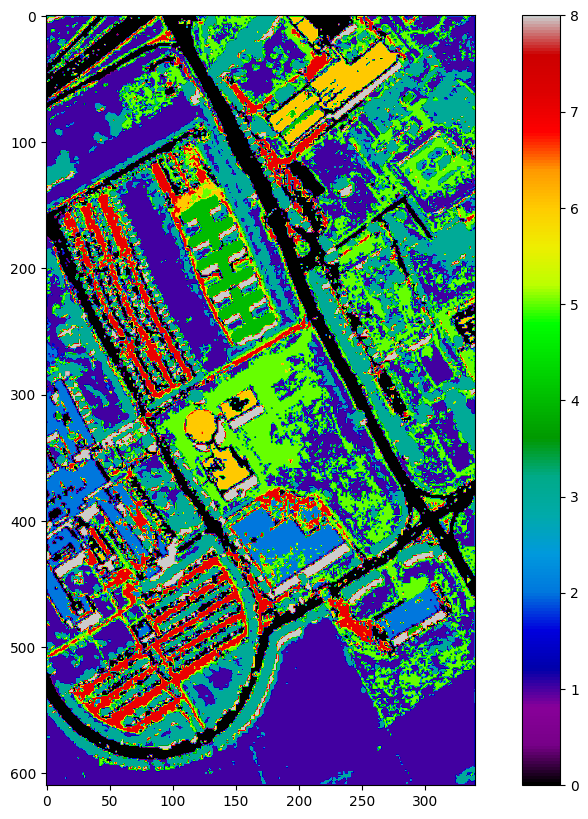

In [ ]:
plot_data(prediction_reshaped)

## Setting up the K-Means Model.

In [ ]:
import scipy.io
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the PaviaU.mat dataset
mat_data = scipy.io.loadmat('PaviaU.mat')
data = mat_data['paviaU']
# Reshape the data
data = np.reshape(data, (data.shape[0] * data.shape[1], data.shape[2]))

# Flatten the data for clustering
data_flat = data.reshape(-1, data.shape[-1])

data = data_flat[150000:]
data.shape

(57400, 103)

In [ ]:
data

array([[1876, 1868, 1960, ..., 3400, 3341, 3404],
       [1799, 1918, 2024, ..., 3413, 3456, 3479],
       [1926, 1989, 2003, ..., 3412, 3397, 3465],
       ...,
       [ 593,  387,  428, ..., 2382, 2407, 2423],
       [ 593,  751,  655, ..., 2312, 2308, 2289],
       [ 889,  720,  449, ..., 2416, 2447, 2485]], dtype=uint16)

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Apply K-means clustering
n_clusters = 9  # You can adjust the number of clusters as needed
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
labels = kmeans.fit_predict(data_flat)

# # Visualize the results
# plt.figure(figsize=(10, 6))

# # Scatter plot of the data points colored by cluster labels
# plt.scatter(data_flat[:, 0], data_flat[:, 1], c=labels, cmap='viridis', s=2)

# plt.xlabel('X')
# plt.ylabel('Y')
# plt.title('K-means Clustering of PaviaU.mat Dataset')
# plt.colorbar(label='Cluster')

# plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [ ]:
labels_reshaped = labels.reshape(gt.shape)
gt=labels_reshaped
gt.shape

(610, 340)

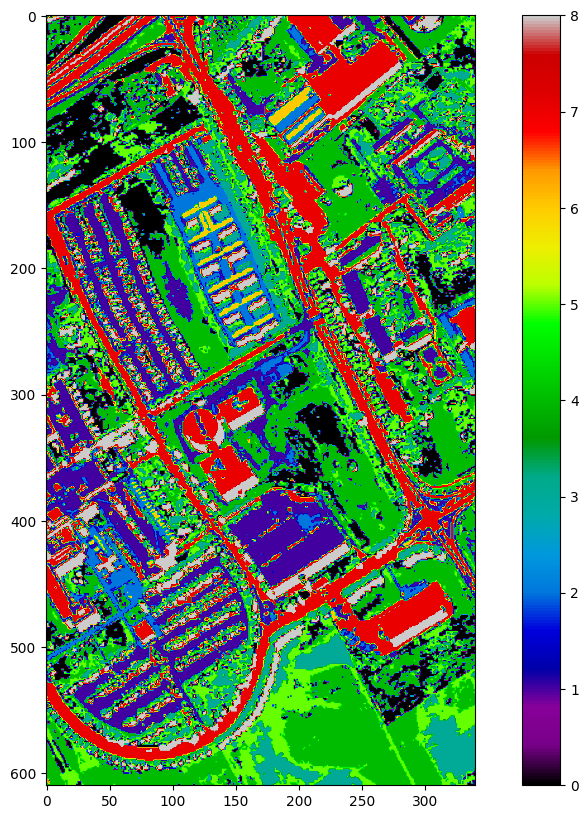

In [ ]:
plot_data(labels_reshaped)

In [ ]:
from sklearn import metrics
# Compute silhouette score
silhouette_avg = metrics.silhouette_score(data_flat, labels)
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.3598395668772048


## Setting up the Gaussian Mixture model.

In [ ]:
from sklearn.mixture import GaussianMixture

gaussian_model = GaussianMixture(n_components=9)
gaussian_model.fit(data_flat)
gaussian_result = gaussian_model.predict(data_flat)

In [ ]:
# get all of the unique clusters
gaussian_clusters = np.unique(gaussian_result)

In [ ]:
gc_reshaped = gaussian_result.reshape(gt.shape)
gt=gc_reshaped
gt.shape

(610, 340)

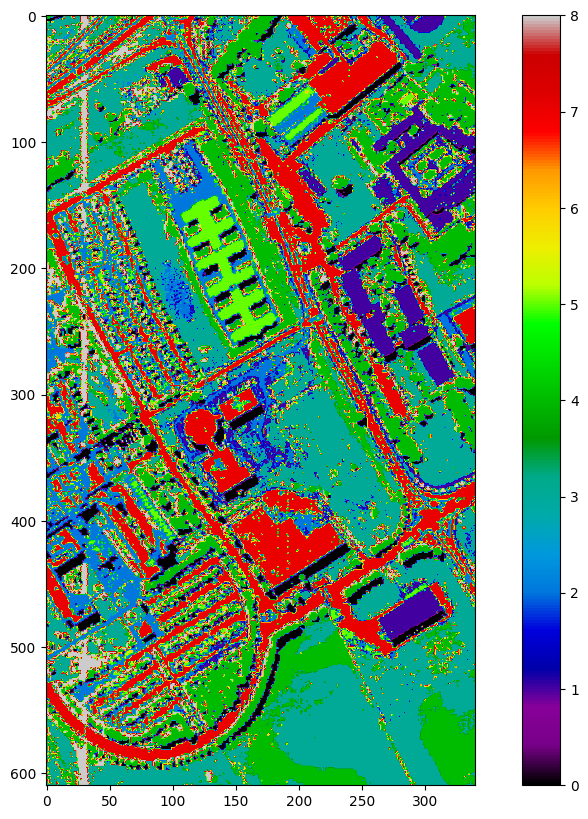

In [ ]:
plot_data(gc_reshaped)

In [ ]:
# Compute silhouette score
silhouette_avg = metrics.silhouette_score(data_flat, gaussian_result)
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.1356658677761381
